## Text classification

Let's try several methods for classification

In [ ]:
import pandas as pd
import numpy as np
import torch
torch.cuda.is_available()

from torchtext import datasets
from torchtext.legacy import datasets

from torchtext.legacy.data import Field, LabelField
from torchtext.legacy.data import BucketIterator

from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

We will use the torchtext library

In [ ]:
TEXT = Field(sequential=True, lower=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The dataset on which we will conduct experiments are comments on films from the IMDB site.

In [ ]:
train, test = datasets.IMDB.splits(TEXT, LABEL)  # download the dataset
train, valid = train.split(random_state=random.seed(SEED))

In [ ]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test), 
    batch_size = 64,
    sort_within_batch = True,
    device = device)

## RNN

We will use the recurrent neural network LSTM.

In [ ]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, 
                                      embedding_dim= self.embedding_dim, 
                                      padding_idx=self.pad_idx
                                      )
        
        self.rnn = nn.LSTM(input_size=self.embedding_dim, 
                          hidden_size=self.hidden_dim, 
                          num_layers=self.n_layers, 
                          dropout=self.dropout, 
                          bidirectional=self.bidirectional
                          )
        
        self.fc = nn.Linear(self.hidden_dim * 2, self.output_dim)
        self.dropout = nn.Dropout(self.dropout)
        self.sig = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        #text = [sent len, batch size]
        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]

        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        #output = [sent len, batch_size, hid dim * num directions]
        #hidden = [num layer * num direction, batch_size, hid dim]
        #cell = [num layer * num direction, batch_size, hid dim]

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        #hidden = [batch size, hid dim * num directions]
        hidden = self.dropout(hidden)
        hidden = self.fc(hidden)
        #hidden = [batch_size, out dim]
        hidden = self.sig(hidden)

        return hidden

In [ ]:
vocab_size = len(TEXT.vocab)
emb_dim = 200
hidden_dim = 50
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
patience=3

In [ ]:
model = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)

In [ ]:
model = model.to(device)

In [ ]:
import torch.optim as optim

max_epochs = 20

opt = optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

Let's train the model

In [ ]:
import numpy as np

min_loss = np.inf
cur_patience = 0
history = []

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:

        opt.zero_grad()
        x = batch.text[0]
        length = batch.text[1].to('cpu')
        y = batch.label
        output = model(x, length)
        output = output.reshape(-1)

        loss = loss_func(output, y)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        history.append(loss.item())
        
    train_loss /= len(train_iter)

    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        x = batch.text[0]
        length = batch.text[1].to('cpu')
        y = batch.label
        output = model(x, length)
        output = output.reshape(-1)

        loss = loss_func(output, y)
        val_loss += loss.item()

    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.6816008012660228, Validation Loss: 0.6442553034778369


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.6194906933029203, Validation Loss: 0.6131157877586656


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.5769025792170616, Validation Loss: 0.5935971426256632


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.5514884654187808, Validation Loss: 0.5887605174113129


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.5364233923219416, Validation Loss: 0.6037296973547693


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.5463173128392574, Validation Loss: 0.5892901860051236


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

<All keys matched successfully>

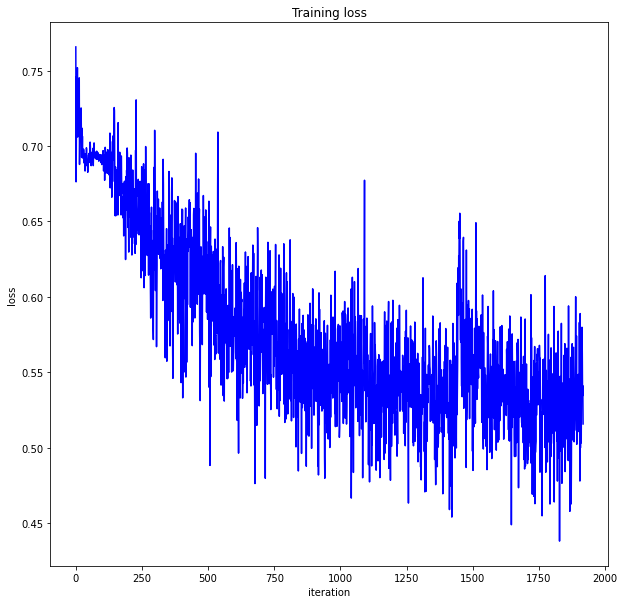

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

Let's calculate the f1-score of the classifier on the test dataset

In [ ]:
from sklearn.metrics import f1_score

y_true = np.array([])
y_pred = np.array([])
for it, batch in enumerate(test_iter):
    y_true = np.hstack([y_true, batch.label.cpu().detach().numpy()])
    y_pred = np.hstack([y_pred, torch.round(model(batch.text[0], batch.text[1].to('cpu')).cpu()).reshape(-1).cpu().detach().numpy()])

print(f1_score(y_true, y_pred))

0.8245460428642126


**Answer** 0.82

## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Let's try a convolutional neural network

In [ ]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first тк мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, out_channels, kernel_sizes, dropout=0.5):
        super().__init__()

        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.out_channels = out_channels
        self.kernel_sizes = kernel_sizes
        self.dropout = dropout
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)

        self.conv_0 = nn.Conv1d(
                                in_channels=self.emb_dim, 
                                out_channels=self.out_channels, 
                                kernel_size=kernel_sizes[0], 
                                padding=1, 
                                stride=2
                                )
        
        self.conv_1 = nn.Conv1d(
                                in_channels=self.emb_dim, 
                                out_channels=self.out_channels, 
                                kernel_size=kernel_sizes[1], 
                                padding=1, 
                                stride=2
                                )
        
        self.conv_2 = nn.Conv1d(
                                in_channels=self.emb_dim, 
                                out_channels=self.out_channels, 
                                kernel_size=kernel_sizes[2], 
                                padding=1, 
                                stride=2
                                )

        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 1)
        self.sig = nn.Sigmoid()
        self.dropout = nn.Dropout(self.dropout)
        
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1)
        #embedded = [batch size, emb dim, sent len]

        conved_0 = F.relu(self.conv_0(embedded))
        conved_1 = F.relu(self.conv_1(embedded))
        conved_2 = F.relu(self.conv_2(embedded))
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
 
        return self.sig(self.fc(cat))

In [ ]:
kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
out_channels=64
dropout = 0.5
dim = 300

model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, dropout=dropout)

In [ ]:
model = model.to(device)

In [ ]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
max_epochs = 30

Training

In [ ]:
min_loss = np.inf
cur_patience = 0
history = []

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        
        opt.zero_grad()
        x = batch.text
        y = batch.label
        output = model(x)
        output = output.reshape(-1)

        loss = loss_func(output, y)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        history.append(loss.item())

    train_loss /= len(train_iter)
    val_loss = 0.0

    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:

        x = batch.text[0].T
        y = batch.label
        output = model(x)
        output = output.reshape(-1)

        loss = loss_func(output, y)
        val_loss += loss.item()

    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.6942551605892877, Validation Loss: 0.693132445973865


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.6927058949087658, Validation Loss: 0.6928957458269798


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.6716278056158637, Validation Loss: 0.6305886034743261


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.6350812898935193, Validation Loss: 0.6168720737352209


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.6141319405423463, Validation Loss: 0.5999440697290129


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.5970082313474947, Validation Loss: 0.5985374672938202


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.5849239069179897, Validation Loss: 0.5873409196481867


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.5762871251489124, Validation Loss: 0.5806458175687467


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.5640403201980312, Validation Loss: 0.576995606644679


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.5555897998983843, Validation Loss: 0.5755225718021393


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 0.5481249407260087, Validation Loss: 0.573634931596659


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 0.540788254163561, Validation Loss: 0.5708405203738455


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 0.5336287032513722, Validation Loss: 0.5703359524072227


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 0.5298358878515063, Validation Loss: 0.5702193546093116


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 0.5251441352123761, Validation Loss: 0.5706441245846829


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 0.5210072587441353, Validation Loss: 0.5697292533971495


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 0.5187142078023758, Validation Loss: 0.5695035816249201


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 0.5163350733962372, Validation Loss: 0.5696853656890029


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

<All keys matched successfully>

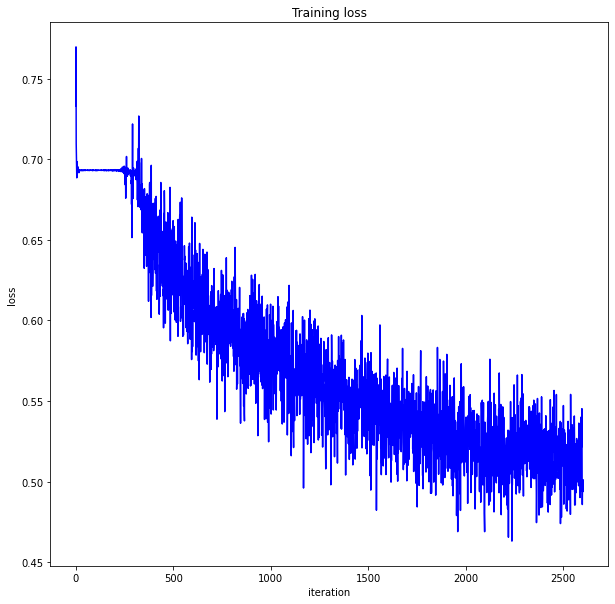

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

Let's calculate the f1-score of the classifier on the test dataset

In [ ]:
y_true = np.array([])
y_pred = np.array([])
for it, batch in enumerate(test_iter):
    y_true = np.hstack([y_true, batch.label.cpu().numpy()])
    y_pred = np.hstack([y_pred, torch.round(model(batch.text).cpu()).reshape(-1).cpu().detach().numpy()])

print(f1_score(y_true, y_pred))

0.8280083857442347


**Answer**: 0.83

## Interpretability

Let's see where our model is looking. Just run the code below.

In [ ]:
!pip install -q captum

     |████████████████████████████████| 1.4 MB 7.4 MB/s 


In [ ]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)

In [ ]:
def forward_with_softmax(inp):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=5000, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [ ]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.68 ) , delta:  tensor([1.5579e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.50 ) , delta:  tensor([4.6619e-14], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.73 ) , delta:  tensor([1.4459e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.50 ) , delta:  tensor([6.0748e-15], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.50 ) , delta:  tensor([1.4315e-10], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.50 ) , delta:  tensor([2.5603e-15], device='cuda:0', dtype=torch.float64)


In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.68),pos,1.54,It was a fantastic performance ! pad
pos,neg (0.50),pos,0.97,Best film ever pad pad pad pad
pos,pos (0.73),pos,1.28,Such a great show! pad pad pad
neg,neg (0.50),pos,-0.09,It was a horrible movie pad pad
neg,pos (0.50),pos,0.80,I've never watched something as bad pad
neg,neg (0.50),pos,-0.01,It is a disgusting movie! pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.68),pos,1.54,It was a fantastic performance ! pad
pos,neg (0.50),pos,0.97,Best film ever pad pad pad pad
pos,pos (0.73),pos,1.28,Such a great show! pad pad pad
neg,neg (0.50),pos,-0.09,It was a horrible movie pad pad
neg,pos (0.50),pos,0.80,I've never watched something as bad pad
neg,neg (0.50),pos,-0.01,It is a disgusting movie! pad pad


## Embedding words

Let's try to apply the pre-trained embeddings of the words GloVe

In [ ]:
TEXT.build_vocab(trn, vectors=GloVe())
LABEL.build_vocab(trn)

word_embeddings = TEXT.vocab.vectors

kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                            
100%|█████████▉| 2196016/2196017 [04:24<00:00, 8286.98it/s]


In [ ]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [ ]:
model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=64,
            kernel_sizes=kernel_sizes, dropout=dropout)

word_embeddings = TEXT.vocab.vectors

prev_shape = model.embedding.weight.shape

model.embedding.weight = nn.Parameter(word_embeddings)
assert prev_shape == model.embedding.weight.shape
model.to(device)

opt = torch.optim.Adam(model.parameters())

Trainig

In [ ]:
min_loss = np.inf
cur_patience = 0
history = []

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 

        opt.zero_grad()
        x = batch.text
        y = batch.label
        output = model(x)
        output = output.reshape(-1)

        loss = loss_func(output, y)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        history.append(loss.item())

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        x = batch.text[0].T
        y = batch.label
        output = model(x)
        output = output.reshape(-1)

        loss = loss_func(output, y)
        val_loss += loss.item()
        
    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.6596819771467334, Validation Loss: 0.5952207814838927


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.5795673697534269, Validation Loss: 0.5714803070335065


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.5504708568545154, Validation Loss: 0.5649307925822371


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.531886070314115, Validation Loss: 0.563148287393279


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.5201157814394819, Validation Loss: 0.5617189490694111


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.5142782010736257, Validation Loss: 0.5613563841177245


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.5114119696791155, Validation Loss: 0.5615425935741198


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.5096037738079572, Validation Loss: 0.5625759701607591


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

<All keys matched successfully>

Let's calculate the f1-score of the classifier on the test dataset

In [ ]:
y_true = np.array([])
y_pred = np.array([])
for it, batch in enumerate(test_iter):
    y_true = np.hstack([y_true, batch.label.cpu().numpy()])
    y_pred = np.hstack([y_pred, torch.round(model(batch.text).cpu()).reshape(-1).cpu().detach().numpy()])

print(f1_score(y_true, y_pred))

0.860604102729769


**Answer**: 0.86

The quality is better than on CNN without pre-trained embeddings

Let's check how well everything is!

In [ ]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)
vis_data_records_ig = []

interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.73 ) , delta:  tensor([7.0015e-06], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.50 ) , delta:  tensor([6.4467e-10], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.58 ) , delta:  tensor([5.9253e-07], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.50 ) , delta:  tensor([3.2389e-11], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.56 ) , delta:  tensor([8.2236e-07], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.50 ) , delta:  tensor([9.1580e-11], device='cuda:0', dtype=torch.float64)


In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.73),pos,1.74,It was a fantastic performance ! pad
pos,pos (0.50),pos,1.06,Best film ever pad pad pad pad
pos,pos (0.58),pos,1.54,Such a great show! pad pad pad
neg,pos (0.50),pos,-0.18,It was a horrible movie pad pad
neg,pos (0.56),pos,1.40,I've never watched something as bad pad
neg,neg (0.50),pos,-0.43,It is a disgusting movie! pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.73),pos,1.74,It was a fantastic performance ! pad
pos,pos (0.50),pos,1.06,Best film ever pad pad pad pad
pos,pos (0.58),pos,1.54,Such a great show! pad pad pad
neg,pos (0.50),pos,-0.18,It was a horrible movie pad pad
neg,pos (0.56),pos,1.40,I've never watched something as bad pad
neg,neg (0.50),pos,-0.43,It is a disgusting movie! pad pad
